In [1]:
library(tidyverse)
library(limma)

# import plot functions
source("../../evaluation_utils/plots/eda_plots.R")
source("../../evaluation_utils/filtering/filtering_normalization.R")

Warning message:
“package ‘tidyverse’ was built under R version 4.2.2”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.2”
Warning message:
“package ‘readr’ was built under R version 4.2.2”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.2”
Warning message:
“package ‘lubridate’ was built under R version 4.2.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ──────────────────────────────────────

# Merge data

In [2]:
dataset = 'balanced'
labs_list = c('lab_A', 'lab_B', 'lab_C', 'lab_D' , 'lab_E')  #

path_to_reports = paste0('/home/yuliya/repos/cosybio/FedProt/data/bacterial_data/', dataset, '/')

central_intensities = NULL
central_counts = NULL
central_batch_info = NULL

for (name in labs_list) {
batch_info = read_tsv(paste0(path_to_reports, name, '/metadata.tsv'), show_col_types = FALSE)
intensities = read_tsv(paste0(path_to_reports, name, '/protein_groups_matrix.tsv'), show_col_types = FALSE)
counts = read_tsv(paste0(path_to_reports, name, '/protein_counts.tsv'), show_col_types = FALSE)

if(is.null(central_intensities)){
    central_intensities = intensities
    central_counts = counts
    central_batch_info = batch_info
} else {
    central_intensities = full_join(central_intensities, intensities, by = 'rowname')
    central_counts = full_join(central_counts, counts, by = 'rowname')
    central_batch_info = rbind(central_batch_info, batch_info)
}
}

cat('\n\nDataset: ', dataset, "\n")
cat('\tNumber of proteins: ', nrow(central_intensities), '\n')
cat('\tNumber of samples: ', ncol(central_intensities)-1, '\n')

central_intensities <- central_intensities %>% column_to_rownames('rowname')
central_counts <- central_counts %>% column_to_rownames('rowname')
central_intensities <- central_intensities[, central_batch_info$file]

central_intensities <- filter_by_condition(central_intensities, central_batch_info, 
    'file', c('Glu', 'Pyr'), 'condition')
central_intensities <- filter_na_proteins(central_intensities, central_batch_info, "file")

# select minimal count across column for each protein (with na.rm = TRUE)
central_counts$count <- apply(central_counts, 1, min, na.rm = TRUE)
central_counts <- central_counts %>% select(count) %>% as.data.frame()

# median norm
# central_intensities <- medianNorm(central_intensities) %>% as.data.frame()

central_intensities <- log2(central_intensities + 1)



Dataset:  balanced 
	Number of proteins:  3059 
	Number of samples:  118 
Filtering by condition - two not-NA per condition
	Before filtering: 3059 118 
	After filtering: 2862 118 
Filtering out features that have NAs in all columns
	Before filtering: 2862 118 
	After filtering: 2862 118 


In [3]:
# print all rows with QC in file
central_batch_info <- central_batch_info %>% 
    #filter(grepl('QC', file)) 
    mutate(QC_condition =   
        ifelse(file %in% c("CVT09_QC1_LabE_X023"), 'QC4', 
        ifelse(file %in% c("CVT09_QC4_LabE_X026"), 'QC3', 
        ifelse(file %in% c("CVT09_QC3_LabE_X025"), 'QC1', 
            ifelse(grepl('QC1', file), 'QC1', 
            ifelse(grepl('QC2', file), 'QC2', 
            ifelse(grepl('QC3', file), 'QC3', 
            ifelse(grepl('QC4', file), 'QC4', 
                ifelse(file %in% c("BBM_673_P283_01_VEB_011"), 'QC1', 
                ifelse(file %in% c("BBM_673_P283_01_VEB_012"), 'QC2', 
                ifelse(file %in% c("BBM_673_P283_01_VEB_023"), 'QC3', 
                ifelse(file %in% c("BBM_673_P283_01_VEB_024"), 'QC4', condition))))))))))))


central_batch_info <- central_batch_info %>%
    mutate(lab = as.factor(lab), QC_condition = as.factor(QC_condition))

In [4]:
# write central_batch_info to file
central_batch_info %>%
    filter(!grepl('QC', QC_condition)) %>%
    write_tsv(paste0(path_to_reports, 'metadata_short.tsv'))

# same for each lab 
for(lab_ in labs_list){
    lab_batch_info <- central_batch_info %>% filter(lab == lab_)
    lab_batch_info %>%
        filter(!grepl('QC', QC_condition)) %>%
        write_tsv(paste0(path_to_reports, lab_, '/metadata_short.tsv'))
}

In [5]:
design <- model.matrix(~ condition, data = central_batch_info)
pg_corrected <- removeBatchEffect(central_intensities, batch=central_batch_info$lab, design=design)


Warning message:
“Partial NA coefficients for 590 probe(s)”


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


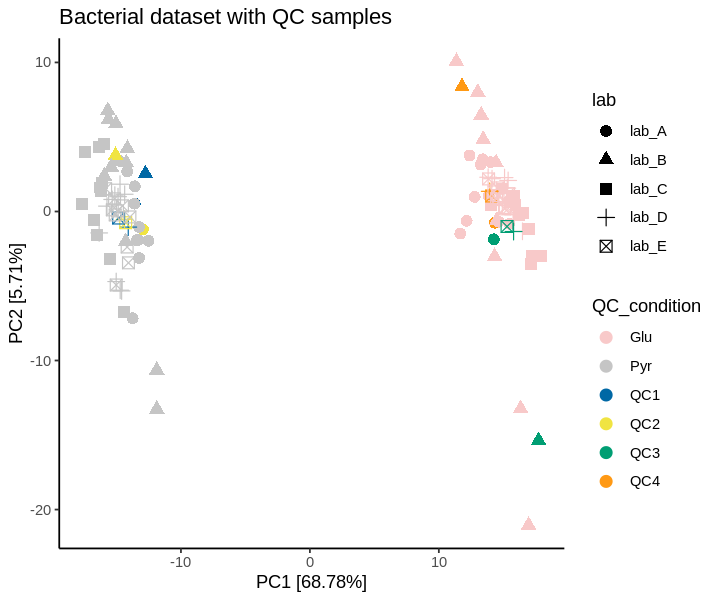

In [6]:
plot_pca <- pca_plot(pg_corrected, central_batch_info, 
    title="Bacterial dataset with QC samples", quantitative_col_name='file', 
    col_col='QC_condition', shape_col='lab')

options(repr.plot.width=6, repr.plot.height=5)
plot_pca +
    # change color of points to more color-blind friendly
    scale_color_manual(values=c("#f8c9c9", "#c5c5c5", "#0068a5",  "#F0E442", "#009E73", "#ff9914")) 